# Actor Critic

In [3]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm

import os
import random
import imageio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [4]:
class RoverGridEnv(gym.Env):
    metadata={'render.modes': ['human']}
    
    def __init__(self,max_ts=20):
        super(RoverGridEnv,self).__init__()
        self.max_ts=max_ts
        self.grid_size=(15,15)
        self.action_space=spaces.Discrete(5)
        self.observation_space=spaces.MultiDiscrete([15,15,15,15,15,15])
        self._init_positions()
        self.actions=[(0,-1),(0,1),(-1,0),(1,0),(0,0)]
        self.reset()

    def _init_positions(self):
        self.rover_positions=np.array([[6,4],[10,4]])
        self.operation_desks=np.array([[6,3],[10,3]])
        self.rooms=np.array([[4,7],[4,10],[4,13],[8,7],[8,10],[8,13],[12,7],[12,10],[12,13]])
        self.human_position=np.array([8,9])
        self.targets=np.array([[5,10],[9,13]])
        self.rover_done=[False,False]

    def reset(self):
        self.current_step=0
        self._init_positions()
        return self._get_obs()

    def _get_obs(self):
        return np.concatenate((self.rover_positions.flatten(),self.human_position))

    def step(self,actions):
        rwds=np.zeros(2)
        dones=[False,False]
        info={'message': ''}
        for i,action in enumerate(actions):
            if self.rover_done[i]:
                dones[i]=True
                continue
            prev_distance=np.linalg.norm(self.targets[i]-self.rover_positions[i])
            if self._is_human_adjacent(self.rover_positions[i]):
                rwds[i] -= 5
            else:
                delta=np.array(self.actions[action])
                new_position=self.rover_positions[i]+delta
                if self._out_of_bounds(new_position):
                    rwds[i] -= 15
                    continue
                if self._collision(new_position,i):
                    rwds[i] -= 15
                    continue
                self.rover_positions[i]=new_position
                new_distance=np.linalg.norm(self.targets[i]-new_position)
                if new_distance < prev_distance:
                    rwds[i]+=30
                else:
                    rwds[i] -= 20
                if np.array_equal(new_position,self.targets[i]):
                    rwds[i]+=100
                    self.rover_done[i]=True
                    dones[i]=True
        self._move_human()
        self.current_step+=1
        all_done=all(dones) or self.current_step >= self.max_ts
        if all_done and not all(dones):
            info['message']='Maximum number of timestamps reached'
        return self._get_obs(),rwds,dones,info
    
    def _is_human_adjacent(self,position):
        for delta in [(1,1),(1,-1),(-1,1),(-1,-1)]:
            if np.array_equal(position+np.array(delta),self.human_position):
                return True
        return False

    def _out_of_bounds(self,position):
        return not (0 <= position[0] < self.grid_size[0] and 0 <= position[1] < self.grid_size[1])

    def _collision(self,new_position,rover_index):
        if any(np.array_equal(new_position,pos) for pos in np.delete(self.rover_positions,rover_index,axis=0)):
            return True
        if any(np.array_equal(new_position,pos) for pos in self.rooms):
            return True
        if any(np.array_equal(new_position,pos) for pos in self.operation_desks):
            return True
        if np.array_equal(new_position,self.human_position):
            return True
        return False

    def _move_human(self):
        valid_moves=[move for move in self.actions if not self._out_of_bounds(self.human_position+np.array(move))]
        self.human_position+=np.array(valid_moves[random.choice(range(len(valid_moves)))])
  
    def render(self,mode='human',save_path=None):
        fig,ax=plt.subplots(figsize=(7,7))
        ax.set_xlim(0,self.grid_size[0])
        ax.set_ylim(0,self.grid_size[1])
        ax.set_xticks(np.arange(0,15,1))
        ax.set_yticks(np.arange(0,15,1))
        ax.grid(which='both')

        # drawing positions
        for pos in self.rover_positions:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='blue'))
        for pos in self.operation_desks:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='darkgreen'))
        for pos in self.rooms:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='black'))
        ax.add_patch(Rectangle((self.human_position[0]-0.5,self.human_position[1]-0.5),1,1,color='purple'))
        for pos in self.targets:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='yellow',alpha=0.5))

        if save_path is not None:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()

    def close(self):
        plt.close()

Initial Setup


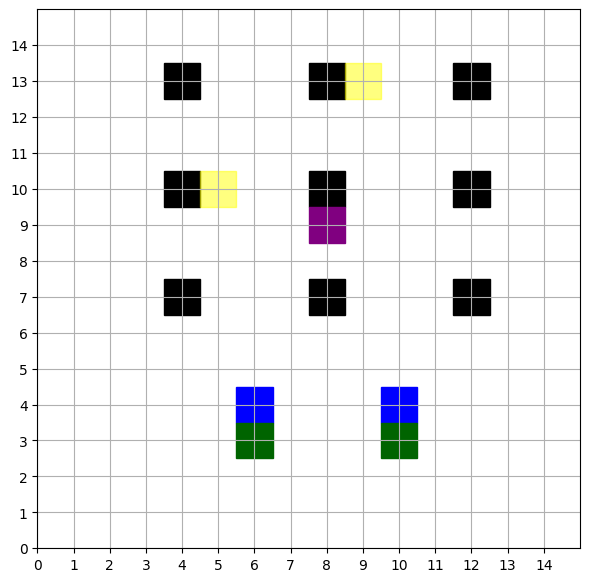

In [5]:
env=RoverGridEnv()
print("Initial Setup")
observation=env.reset()
env.render()

# A2C

In [6]:
class rover_ActorCritic(nn.Module):
    def __init__(self,
                 input_dim,
                 n_actions):
        super(rover_ActorCritic,self).__init__()
        self.actor=nn.Sequential(
            nn.Linear(input_dim,64),nn.ReLU(),
            nn.Linear(64,n_actions),nn.Softmax(dim=-1))
        self.critic=nn.Sequential(
            nn.Linear(input_dim,64),nn.ReLU(),
            nn.Linear(64,1))
    def forward(self,x):
        return self.actor(x),self.critic(x)

In [7]:
class A2CAgent:
    def __init__(self,
                 env,
                 lr_actor=0.001,
                 lr_critic=0.001,
                 gamma=0.99,
                 n_steps=2):
        self.env=env
        self.actor_critic1=rover_ActorCritic(env.observation_space.shape[0],
                                               env.action_space.n)
        self.actor_critic2=rover_ActorCritic(env.observation_space.shape[0],
                                               env.action_space.n)
        self.optimizer_actor1=optim.Adam(self.actor_critic1.actor.parameters(),
                                           lr=lr_actor)
        self.optimizer_critic1=optim.Adam(self.actor_critic1.critic.parameters(),
                                            lr=lr_critic)
        self.optimizer_actor2=optim.Adam(self.actor_critic2.actor.parameters(),
                                           lr=lr_actor)
        self.optimizer_critic2=optim.Adam(self.actor_critic2.critic.parameters(),
                                            lr=lr_critic)
        self.gamma=gamma
        self.n_steps=n_steps

    def select_action(self,
                      stt,
                      actor_critic):
        with torch.no_grad():
            act_probs,_=actor_critic(torch.tensor(stt,
                                                        dtype=torch.float32))
            dist=Categorical(act_probs)
            action=dist.sample()
            log_prob=dist.log_prob(action)
        return action.item(),log_prob.item()

    def compute_advantages(self,
                           rwds,
                           values,
                           nxt_values,
                           gamma=0.99,
                           lambda_=0.95):
        rwds=torch.tensor(rwds,
                               dtype=torch.float32)
        values=torch.tensor(values,
                              dtype=torch.float32)
        nxt_values=torch.tensor(nxt_values,
                                   dtype=torch.float32)
        deltas=rwds+gamma*nxt_values-values
        advt=torch.zeros_like(deltas)
        for i in reversed(range(len(deltas))):
            advt[i]=deltas[i]+gamma*lambda_*(advt[i+1] if i+1 < len(advt) else 0)
        return advt

    def update(self,
               actor_critic,
               optimizer_actor,
               optimizer_critic,
               stts,
               actions,
               rwds,dones,
               next_states):
        stts=torch.tensor(stts,
                              dtype=torch.float32)
        actions=torch.tensor(actions,
                               dtype=torch.int64)
        rwds=torch.tensor(rwds,
                               dtype=torch.float32)
        dones=torch.tensor(dones,
                             dtype=torch.float32)
        next_states=torch.tensor(next_states,
                                   dtype=torch.float32)
        _,critic_values=actor_critic(stts)
        _,next_critic_values=actor_critic(next_states)
        advt=self.compute_advantages(rwds,
                                             critic_values,
                                             next_critic_values,
                                             self.gamma)
        td_targets=rwds+self.gamma*(1-dones)*next_critic_values
        act_probs,_=actor_critic(stts)
        dist=Categorical(act_probs)
        log_probs=dist.log_prob(actions)

        a_loss=-(log_probs*advt).mean()
        c_loss=nn.MSELoss()(critic_values.squeeze(),
                                   td_targets)
        entropy_bonus=-dist.entropy().mean()*0.01
        a_loss+=entropy_bonus
        optimizer_actor.zero_grad()
        optimizer_critic.zero_grad()
        a_loss.backward(retain_graph=True)
        c_loss.backward()
        torch.nn.utils.clip_grad_norm_(actor_critic.parameters(),0.2)
        optimizer_actor.step()
        optimizer_critic.step()

    def train(self,num_episodes):
        episode_rewards=[]
        with tqdm(total=num_episodes,desc="Training Episodes") as pbar:
            for _ in range(num_episodes):
                stt=self.env.reset()
                total_episode_reward=0
                while True:
                    states1,actions1,rewards1,dones1,next_states1=[],[],[],[],[]
                    states2,actions2,rewards2,dones2,next_states2=[],[],[],[],[]

                    for _ in range(self.n_steps):
                        action1,_=self.select_action(stt,self.actor_critic1)
                        action2,_=self.select_action(stt,self.actor_critic2)
                        next_state,reward,done,_=self.env.step([action1,action2])
                        total_episode_reward+=sum(reward)

                        states1.append(stt)
                        actions1.append(action1)
                        rewards1.append(reward[0])
                        dones1.append(done[0])
                        next_states1.append(next_state)

                        states2.append(stt)
                        actions2.append(action2)
                        rewards2.append(reward[1])
                        dones2.append(done[1])
                        next_states2.append(next_state)
                        stt=next_state
                        if any(done):
                            break

                    self.update(self.actor_critic1,
                                self.optimizer_actor1,
                                self.optimizer_critic1,
                                states1,
                                actions1,
                                rewards1,
                                dones1,
                                next_states1)
                    self.update(self.actor_critic2,
                                self.optimizer_actor2,
                                self.optimizer_critic2,
                                states2,
                                actions2,
                                rewards2,
                                dones2,
                                next_states2)
                    if self.env.current_step >= self.env.max_ts or any(done):
                        episode_rewards.append(total_episode_reward)
                        pbar.set_postfix({'Reward': total_episode_reward})
                        pbar.update(1)
                        break
        return episode_rewards

In [ ]:
env=RoverGridEnv(max_ts=30)
agent=A2CAgent(env)
episode_rewards=agent.train(num_episodes=1000)

Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\91740\AppData\Local\Temp\ipykernel_8108\1752603705.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32)
C:\Users\91740\AppData\Local\Temp\ipykernel_8108\1752603705.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(values, dtype=torch.float32)
C:\Users\91740\AppData\Local\Temp\ipykernel_8108\1752603705.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_values = torch.tensor(next_values, dt

Training Episodes: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s, Reward=590]


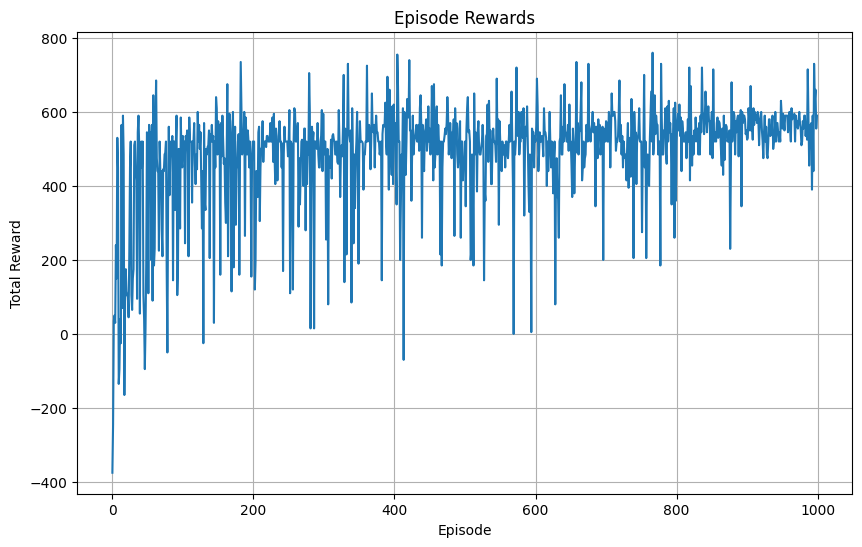

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

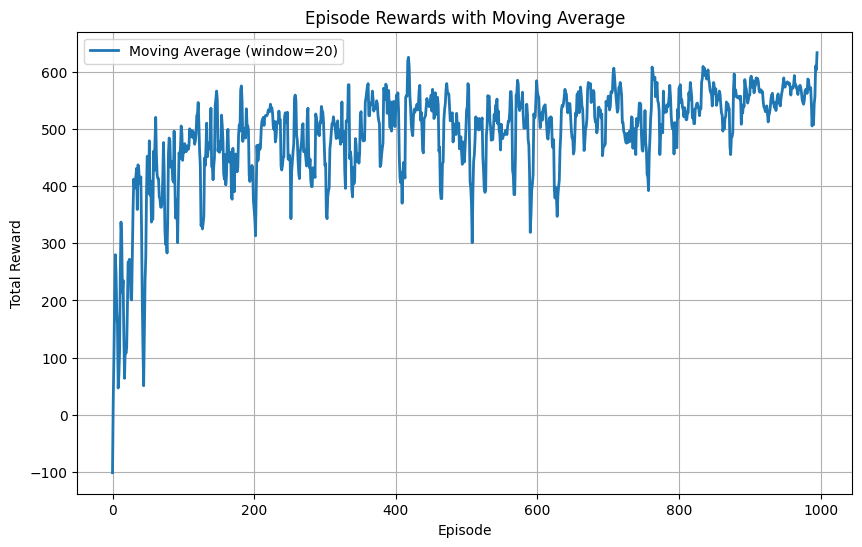

In [ ]:
def moving_average(data,
                   window_size=5):
    cum_sum=np.cumsum(np.insert(data,0,0))
    return (cum_sum[window_size:]-cum_sum[:-window_size])/window_size

rewards_moving_avg=moving_average(episode_rewards)
plt.figure(figsize=(10,6))
plt.plot(rewards_moving_avg,label="Moving Average (window=20)",linewidth=2)
plt.title("Episode Rewards with Moving Average")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()

Episode 0: Agent 1 Reward: 320.0,Agent 2 Reward: 245.0
Episode 1: Agent 1 Reward: 390.0,Agent 2 Reward: 245.0
Episode 2: Agent 1 Reward: 315.0,Agent 2 Reward: 250.0
Episode 3: Agent 1 Reward: 310.0,Agent 2 Reward: 210.0
Episode 4: Agent 1 Reward: 315.0,Agent 2 Reward: 250.0
Episode 5: Agent 1 Reward: 310.0,Agent 2 Reward: 210.0
Episode 6: Agent 1 Reward: 270.0,Agent 2 Reward: 230.0
Episode 7: Agent 1 Reward: 390.0,Agent 2 Reward: 25.0
Episode 8: Agent 1 Reward: 295.0,Agent 2 Reward: 265.0
Episode 9: Agent 1 Reward: 350.0,Agent 2 Reward: 185.0


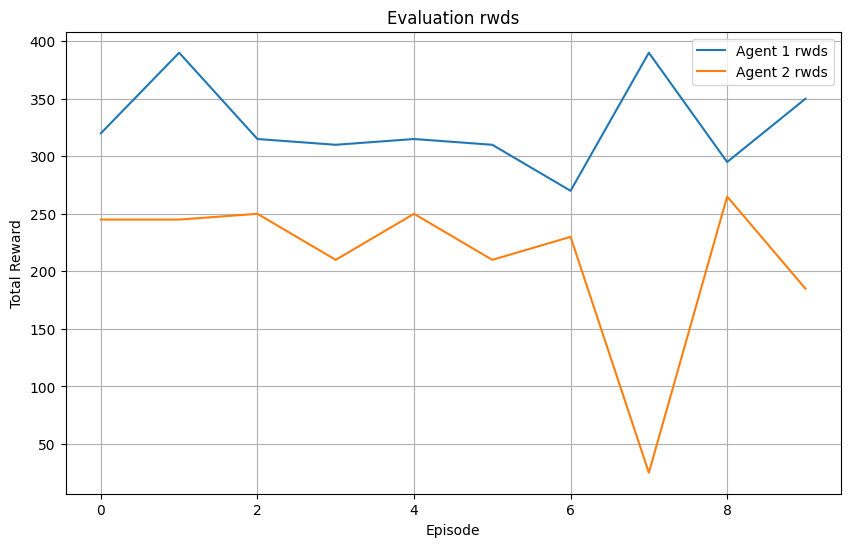

In [11]:
def evaluate_agents(env,actor_critic1,actor_critic2,num_episodes=10):
    rewards_agent1=[]
    rewards_agent2=[]

    for episode in range(num_episodes):
        stt=env.reset()
        total_reward1=0
        total_reward2=0

        for step in range(env.max_ts):
            state_tensor=torch.tensor(stt,dtype=torch.float32).unsqueeze(0)
            action_probs1,_=actor_critic1(state_tensor)
            action_probs2,_=actor_critic2(state_tensor)
            action1=Categorical(action_probs1).sample().item()
            action2=Categorical(action_probs2).sample().item()
            next_state,rwds,done,_=env.step([action1,action2])
            total_reward1+=rwds[0]
            total_reward2+=rwds[1]
            stt=next_state
            if any(done):
                break

        rewards_agent1.append(total_reward1)
        rewards_agent2.append(total_reward2)
        print(f"Episode {episode}: Agent 1 Reward: {total_reward1},Agent 2 Reward: {total_reward2}")

    plt.figure(figsize=(10,6))
    plt.plot(rewards_agent1,label="Agent 1 rwds")
    plt.plot(rewards_agent2,label="Agent 2 rwds")
    plt.title("Evaluation rwds")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

env=RoverGridEnv(max_ts=30)
evaluate_agents(env,agent.actor_critic1,agent.actor_critic2,num_episodes=10)